In [110]:
## La couche d'encodage est le label

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
NB_LABEL = 10

In [5]:
def weight_variable(shape):
    stddev = np.sqrt(1. / np.prod(shape[:-1]))
    print(stddev)
    initial = tf.random_normal(shape, stddev = stddev)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [7]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, NB_LABEL])

In [8]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

0.2


In [9]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [10]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

0.0353553390593


In [12]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

0.0178571428571


In [77]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_logit = tf.matmul(h_fc1, W_fc2) + b_fc2

0.03125


In [95]:
indices = tf.argmax(y_logit, 1)

# multinomial softmax draw
#indices = tf.multinomial(y_logit, 1)[:,0]

depth = NB_LABEL
y_hat = tf.one_hot(indices, depth)

### Decoder

In [96]:
'''W_fc3 = weight_variable([10, 1024])
b_fc3 = bias_variable([1024])

#h_decoder = tf.nn.relu(tf.matmul(tf.nn.softmax(y_logit), W_fc3) + b_fc3)
h_decoder = tf.nn.relu(tf.matmul(y_hat * y_logit, W_fc3) + b_fc3)
#h_decoder = tf.matmul(y_hat, W_fc3) + b_fc3

W_fc4 = weight_variable([1024, 784])
b_fc4 = bias_variable([784])

x_gen = tf.matmul(h_decoder, W_fc4) + b_fc4'''


W_fc3 = weight_variable([10, 784])
b_fc3 = bias_variable([784])
#x_gen = tf.matmul(tf.nn.softmax(y_logit), W_fc3) + b_fc3
x_gen = tf.matmul(y_hat, W_fc3) + b_fc3

#x_gen = tf.matmul(y_hat * y_logit, W_fc3) + b_fc3


0.316227766017


In [97]:
correct_prediction = tf.cast(tf.equal(indices, tf.argmax(y_, 1)), tf.float32)
reward = correct_prediction - (1 - correct_prediction)
#reward_KL_plus = 1 #correct_prediction
#reward_KL_moins = 1 - correct_prediction

In [98]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

p = tf.nn.softmax(y_logit)
q = 1. / NB_LABEL

#KL = tf.reduce_sum(p * y_logit,reduction_indices=1)
KL_ref = tf.reduce_sum(p * tf.log(p/q), reduction_indices=1)
KL = tf.reduce_mean(KL_ref) # + reward_KL_moins * (- tf.log(0.1) - KL_ref))
#KL = tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit) #!! KL(1_\hat{y})
#KL = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logit)) #!! KL(1_\hat{y})

#cross_entropy_loss = tf.reduce_mean(reward * tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x), reduction_indices=1))
#reward = 1
cross_entropy_loss = tf.reduce_mean(reward  * tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit)) 
#cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x))

reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x), reduction_indices = 1))
#rewarded_loss = reward * (KL + cross_entropy_loss)

rewarded_loss = KL +  cross_entropy_loss + reconstruction_loss
                              
train_step = tf.train.AdamOptimizer(1e-4).minimize(rewarded_loss)
accuracy = tf.reduce_mean(correct_prediction)



In [99]:
sess = tf.InteractiveSession()

In [100]:
#sess.run(KL, feed_dict={x: batch[0], y_: batch[1]})
#sess.run(reward, feed_dict={x: batch[0], y_: batch[1]})


In [101]:
#sess.run(rewarded_cross_entropy, feed_dict={x: batch[0], y_: batch[1]})

In [102]:
sess.run(tf.global_variables_initializer())

In [103]:
for i in range(20000):
    batch = mnist.train.next_batch(50)
    #print(reward.eval(feed_dict={x: batch[0], y_: batch[1]}))
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 1.0})
        consistency_loss = np.mean(KL.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        code_loss = np.mean(cross_entropy_loss.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        reco_loss = np.mean(reconstruction_loss.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        print('step %d, training accuracy %g, consistency loss : %g, code_loss %g, reconstr_loss %g' % (i, train_accuracy, consistency_loss, code_loss,  reco_loss))
    train_step.run(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 0.5})



step 0, training accuracy 0.08, consistency loss : 0.0199928, code_loss -1.68037, reconstr_loss 554.237
step 100, training accuracy 0.8, consistency loss : 0.306415, code_loss 0.476682, reconstr_loss 547.511
step 200, training accuracy 0.9, consistency loss : 0.399056, code_loss 0.663301, reconstr_loss 543.162
step 300, training accuracy 0.98, consistency loss : 0.45922, code_loss 0.788514, reconstr_loss 538.489
step 400, training accuracy 1, consistency loss : 0.418548, code_loss 0.874703, reconstr_loss 532.4
step 500, training accuracy 0.94, consistency loss : 0.403554, code_loss 0.720719, reconstr_loss 527.521
step 600, training accuracy 0.98, consistency loss : 0.431441, code_loss 0.798912, reconstr_loss 523.35
step 700, training accuracy 1, consistency loss : 0.42575, code_loss 0.850445, reconstr_loss 517.767
step 800, training accuracy 0.98, consistency loss : 0.421299, code_loss 0.822363, reconstr_loss 512.466
step 900, training accuracy 0.96, consistency loss : 0.429141, code_l

step 8000, training accuracy 1, consistency loss : 0.459303, code_loss 0.752703, reconstr_loss 282.257
step 8100, training accuracy 1, consistency loss : 0.442037, code_loss 0.781355, reconstr_loss 286.358
step 8200, training accuracy 1, consistency loss : 0.468671, code_loss 0.743004, reconstr_loss 280.726
step 8300, training accuracy 1, consistency loss : 0.455671, code_loss 0.754676, reconstr_loss 285.906
step 8400, training accuracy 1, consistency loss : 0.437628, code_loss 0.784845, reconstr_loss 271.192
step 8500, training accuracy 1, consistency loss : 0.466589, code_loss 0.743969, reconstr_loss 275.507
step 8600, training accuracy 1, consistency loss : 0.450002, code_loss 0.770517, reconstr_loss 281.849
step 8700, training accuracy 0.98, consistency loss : 0.453451, code_loss 0.706267, reconstr_loss 285.341
step 8800, training accuracy 1, consistency loss : 0.465583, code_loss 0.747024, reconstr_loss 268.8
step 8900, training accuracy 1, consistency loss : 0.478524, code_loss 0

step 16000, training accuracy 1, consistency loss : 0.44479, code_loss 0.760324, reconstr_loss 198.167
step 16100, training accuracy 1, consistency loss : 0.455786, code_loss 0.750142, reconstr_loss 210.007
step 16200, training accuracy 1, consistency loss : 0.455217, code_loss 0.750424, reconstr_loss 204.489
step 16300, training accuracy 1, consistency loss : 0.448898, code_loss 0.757095, reconstr_loss 208.679
step 16400, training accuracy 1, consistency loss : 0.4602, code_loss 0.745673, reconstr_loss 193.329
step 16500, training accuracy 1, consistency loss : 0.45759, code_loss 0.748731, reconstr_loss 204.745
step 16600, training accuracy 1, consistency loss : 0.459419, code_loss 0.748539, reconstr_loss 202.996
step 16700, training accuracy 1, consistency loss : 0.476185, code_loss 0.727906, reconstr_loss 206.513
step 16800, training accuracy 1, consistency loss : 0.463005, code_loss 0.742511, reconstr_loss 212.809
step 16900, training accuracy 1, consistency loss : 0.453242, code_l

In [1]:
#cross_entropy_loss.eval(feed_dict={x: batch[0], y_: batch[1]})
indices.eval(feed_dict={x: batch[0], y_: batch[1]})

NameError: name 'indices' is not defined

In [104]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


test accuracy 0.994


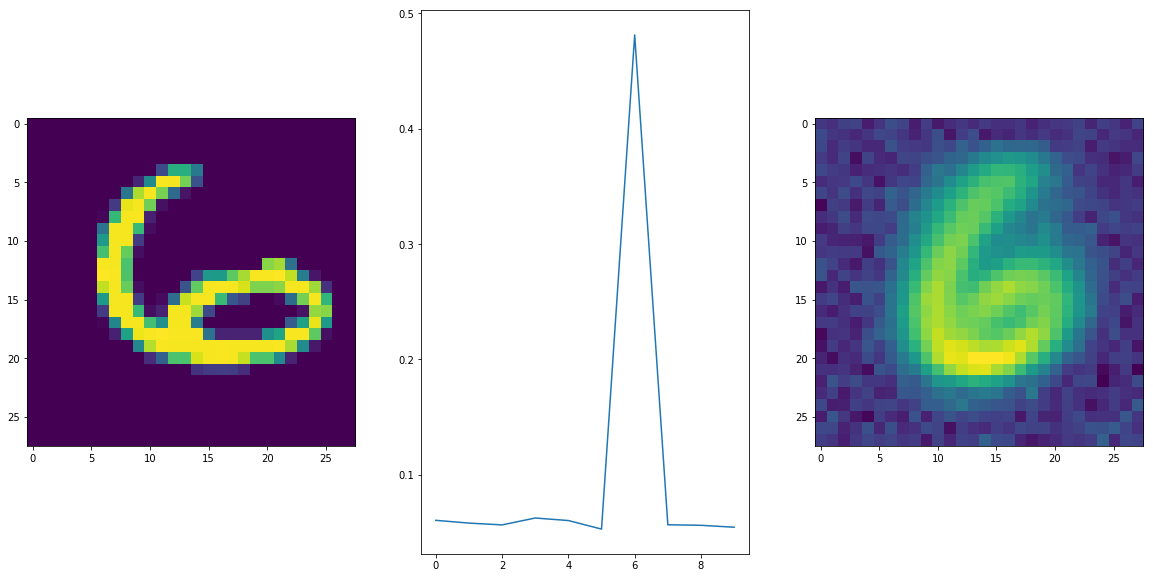

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
code = sess.run(tf.nn.softmax(y_logit), feed_dict={x: batch[0], y_: batch[1]})
pred = sess.run(x_gen, feed_dict={x: batch[0], y_: batch[1]})
i = 5
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.reshape(batch[0][i],(28, 28)))
plt.subplot(1,3,2)
plt.plot(code[i])
plt.subplot(1,3,3)
plt.imshow(np.reshape(pred[i],(28, 28)))



In [ ]:
reward

In [ ]:
sess.run((tf.multinomial(y_logit, 1)[:,0], indices), feed_dict={x: batch[0], y_: batch[1]})

In [ ]:
-np.log(0.1)